2. RNA-Seq Data Analysis. Task: Analyze a provided RNA-Seq dataset and perform differential gene expression analysis.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns

# Example RNA-Seq data (replace with actual dataset)
data = {
    'Gene': ['BRCA1', 'TP53', 'EGFR', 'MYC', 'PIK3CA', 'AKT1', 'PTEN', 'KRAS', 'NRAS', 'CDK2'],
    'Control_1': [520, 180, 350, 620, 400, 210, 500, 600, 320, 410],
    'Control_2': [510, 175, 340, 610, 410, 220, 510, 590, 310, 405],
    'Treatment_1': [700, 210, 500, 740, 480, 190, 550, 650, 300, 500],
    'Treatment_2': [690, 205, 510, 730, 490, 180, 560, 640, 290, 495]
}

# Convert the data to a DataFrame
df = pd.DataFrame(data)
df.set_index('Gene', inplace=True)

# Preview the data
print("Initial Data:")
print(df)

Initial Data:
        Control_1  Control_2  Treatment_1  Treatment_2
Gene                                                  
BRCA1         520        510          700          690
TP53          180        175          210          205
EGFR          350        340          500          510
MYC           620        610          740          730
PIK3CA        400        410          480          490
AKT1          210        220          190          180
PTEN          500        510          550          560
KRAS          600        590          650          640
NRAS          320        310          300          290
CDK2          410        405          500          495


In [2]:
# Assuming df is already defined and structured correctly
conditions = ['Control', 'Control', 'Treatment', 'Treatment']
df_log = np.log2(df + 1)

results = []

for gene in df_log.index:
    y = df_log.loc[gene].values
    
    # Ensure y is a float array
    y = y.astype(float)

    X = pd.get_dummies(conditions, drop_first=True)
    X = sm.add_constant(X)

    # Ensure X is numeric
    X = X.apply(pd.to_numeric, errors='coerce').astype(float)

    # Check for NaN values
    if np.any(np.isnan(y)) or X.isnull().any().any():
        print(f"Skipping gene {gene} due to NaN values in input data.")
        continue

    # Fit the model
    model = sm.OLS(y, X).fit()
    
    fold_change = 2 ** model.params[1]  # Convert log2 fold change back to linear scale
    p_value = model.pvalues[1]
    results.append([gene, fold_change, p_value])

# Convert results to a DataFrame
results_df = pd.DataFrame(results, columns=['Gene', 'Fold_Change', 'P-value'])
results_df['Adj_P-value'] = multipletests(results_df['P-value'], method='fdr_bh')[1]

# Filter significant results
significant_results = results_df[results_df['Adj_P-value'] < 0.05]

# Display results
print("\nDifferential Expression Results:")
print(significant_results)


Differential Expression Results:
     Gene  Fold_Change   P-value  Adj_P-value
0   BRCA1     1.348866  0.001621     0.007047
1    TP53     1.168098  0.013791     0.022986
2    EGFR     1.462509  0.002114     0.007047
3     MYC     1.194817  0.003518     0.008794
4  PIK3CA     1.197072  0.007866     0.015731
6    PTEN     1.098823  0.019515     0.024394
7    KRAS     1.083898  0.019489     0.024394
9    CDK2     1.220326  0.001575     0.007047


/var/folders/yx/fbqgtypx3wz76xxzks5ywwh80000gn/T/ipykernel_6059/3612635271.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fold_change = 2 ** model.params[1]  # Convert log2 fold change back to linear scale
/var/folders/yx/fbqgtypx3wz76xxzks5ywwh80000gn/T/ipykernel_6059/3612635271.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = model.pvalues[1]
/var/folders/yx/fbqgtypx3wz76xxzks5ywwh80000gn/T/ipykernel_6059/3612635271.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behav

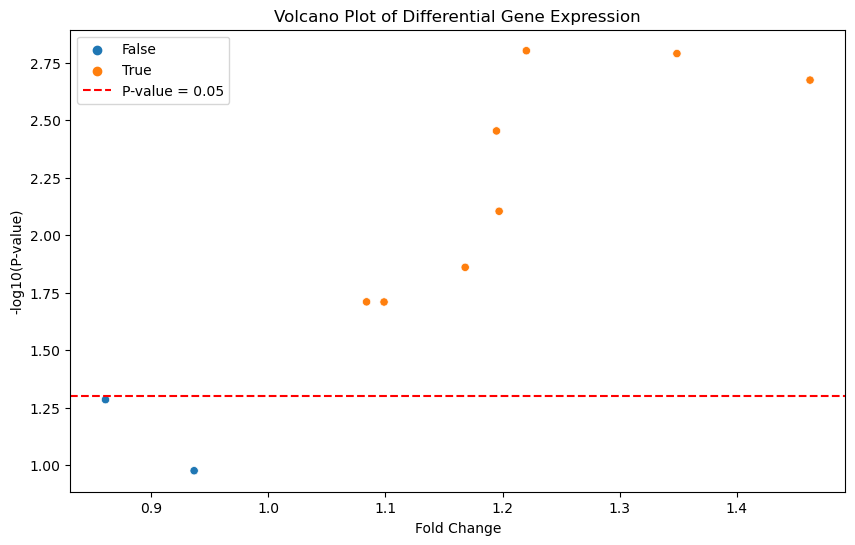

In [3]:
# Volcano plot for visualizing fold change vs significance
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df, x=results_df['Fold_Change'], y=-np.log10(results_df['P-value']), hue=results_df['Adj_P-value'] < 0.05)

plt.axhline(y=-np.log10(0.05), color='red', linestyle='--', label='P-value = 0.05')
plt.xlabel('Fold Change')
plt.ylabel('-log10(P-value)')
plt.title('Volcano Plot of Differential Gene Expression')
plt.legend()
plt.show()